In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import cv2 as cv
import numpy as np
from tqdm.notebook import tqdm

## Visualize cube

### Single frame

#### Functions assignment 2

In [2]:
class VideoReader(cv.VideoCapture):
    def __init__(self, folder, video, K, distortion, initial_frame=0):
        super().__init__(folder + video)
        self.actual_frame = initial_frame
        self.total_frames = self.get(cv.CAP_PROP_FRAME_COUNT)
        self.K = K
        self.distortion = distortion

    def get_actual_frame(self, shape=None, color=False, undistort=True):
        self.set(cv.CAP_PROP_POS_FRAMES, self.actual_frame)
        _, I = self.read()
        if color == 1:
            I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
        elif color == 0:
            I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        # undistortion 
        if undistort:
            I = cv.undistort(I, self.K, self.distortion, None)
        # catch only a subset of image
        if shape:
            I = I[:, shape[0]:shape[1]]
        return I
    
    def get_frame_id(self):
        return self.actual_frame
    
    def next_frame(self, plus_n=1):
        self.actual_frame += plus_n
    
    def is_finished(self):
        return not self.actual_frame < self.total_frames

In [3]:
# find polygons
def find_polygons_LK(I_g):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # find only polygons
    polygon_list = []
    # for each contour search polygon
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)
    # transform in numpy
    polygon_list = np.array(polygon_list, dtype=np.float32)
    # reshape in this way I already have the right format for LK algorithm
    polygon_list = polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2))
    # refine polygons vertices
    accurated_polygon_list = find_more_accurate_points_LK(I_g, polygon_list)
    return accurated_polygon_list
    
# remove polygons that doesn't belong to the bell curve
def is_in_mean_LK(appr_polygon, mean=373.4330426322089, std_dev=57.201333239224326):
    low_bound = mean - 2.3*std_dev
    high_bound = mean + 2.3*std_dev
    return True if low_bound <= cv.arcLength(appr_polygon, True) <= high_bound else False

# increment precision of vertices for each polygon
# this is an improvement, need to have a better corner in all image
def find_more_accurate_points_LK(I_g, polygons, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001), division=150, n_points=5):
    # in order to return the polygon_list with the same order of the input list
    maintain_order = np.arange(0, polygons.shape[0] // n_points, 1)
    # create condition (get casual corner in each polygon)
    # because at the border of circle polygons are smaller, 
    # so I prefer to split in order to have a better result.
    condition = polygons[::n_points, 0] < division
    # split polygons that meet condition
    maintain_order_1 = maintain_order[condition]
    polygons_1 = polygons.reshape((polygons.shape[0] // n_points, n_points, 2))[condition, :, :]
    polygons_1 = polygons_1.reshape((polygons_1.shape[0] * polygons_1.shape[1], 2))
    # split polygons that don't meet condition
    maintain_order_2 = maintain_order[~condition]
    polygons_2 = polygons.reshape((polygons.shape[0] // n_points, n_points, 2))[~condition, :, :]
    polygons_2 = polygons_2.reshape((polygons_2.shape[0] * polygons_2.shape[1], 2))
    # determine better corners for each polygon
    better_polygons_1 = cv.cornerSubPix(I_g, polygons_1, (4,4), (-1,-1), criteria)
    better_polygons_2 = cv.cornerSubPix(I_g, polygons_2, (6,6), (-1,-1), criteria)
    # append the 2 matrix
    better_polygons = np.append(better_polygons_1, better_polygons_2, axis=0)
    # find the right permutation of better_polygons to have the same order of input
    right_position = np.argsort(np.concatenate((maintain_order_1, maintain_order_2)))
    # compute permutation
    shuffled_better_polygons = better_polygons.reshape(better_polygons.shape[0] // n_points, n_points, 2)[right_position, :, :]
    return shuffled_better_polygons.reshape(shuffled_better_polygons.shape[0]*n_points, 2)

# remove polygons that are to close to the cup (lower part of image)
# return right polygons and the position of removed polygons
def check_right_polygons_LK(polygons, n_points=5):
    polygon_list = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))
    # position of removed polygons
    l_del = []
    # find which polygon doesn't respect the rule
    for e, poly in enumerate(polygon_list):
        if not is_in_domain_LK(poly):
            l_del.append(e)
    # delete polygons that don't respect the rule
    polygon_list = np.delete(polygon_list, l_del, axis=0)
    return polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2)), l_del
    
# return False if polygons is in dubious position (near the cup)
def is_in_domain_LK(appr_polygon, above=270, below=820, origin=np.array([160, 540])):
    points_distance = np.linalg.norm(origin - appr_polygon, axis=1)
    # arg sort of points
    arg_sort_points = np.argsort(points_distance)
    # the 2 most distance points from origin
    points = appr_polygon[[arg_sort_points[-1], arg_sort_points[-2]]]
    if any(points[:, 1] > above) and any(points[:, 1] < below) and any(points[:, 0] < origin[0]):
        return False
    else:
        return True

# return only interesting points for each polygon.
# Determine the 2 most distance points from origin and the concave vertex
# From 5 points for each polygon this algorithm returns 3 points
def find_important_points_LK(polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=5):
    # compute distance for each point from origin
    points_distance = np.linalg.norm(origin - polygon_list, axis=1)
    # reshape to create n polygons x 5
    polygon_distance = points_distance.reshape((points_distance.shape[0] // npoints, npoints))
    # find the argsort for each point of each polygon
    argsort_points = np.argsort(polygon_distance, axis=1)
    # trasform list of point in n polygons x 5 x 2 to extract only important point
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//npoints, npoints, 2))
    imp_point_list = []
    for i in range(polygon_list.shape[0]):
        # the 2 most distance point from origin
        d_points = polygon_list[i, argsort_points[i, :2:-1]]
        # mean between points
        d_mean = d_points.mean(axis=0)
        # remaining 3 points
        remain_points = polygon_list[i, argsort_points[i, :3]]
        # compute distance from the point d_mean
        remain_distance = np.linalg.norm(d_mean - remain_points, axis=1)
        # this point is the closest point to d_mean (concave vertex)
        v_point = remain_points[np.argmin(remain_distance)]
        # reshape to compute append
        v_point = v_point.reshape(1, 2)
        # aggregate all importan point for polygon
        imp_point_polygon = np.append(d_points, v_point, axis=0)
        imp_point_list.append(imp_point_polygon)
    return np.array(imp_point_list, dtype=np.float32).reshape(len(imp_point_list)*3, 2)

# find angle for a polygon
def find_angle_LK(thresh, poly, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # mean between the 2 most distance points from origin
    mean_point = poly[:2].mean(axis=0)
    # concave point
    conc_point = poly[-1]
    # determine position
    pos = 0
    # it starts from inner to outer
    for e, q in enumerate(ticks):
        # determine position
        point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
        # if the pixel is close to white I count, because the treshold image is reversed
        if thresh[point[1], point[0]] > 0:
            pos += 2**e
    return pos

# find the angle of each polygon
# idea: compute the angle of central polygon and define the other angles simple with a +1 or -1
def find_angle_list_LK(I_g, polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=3):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # array of True (maintain the corrispondence between element that I have already seen)
    boolean_list = np.ones((polygon_list.shape[0] // npoints), dtype=bool)
    # maintain the corrispondence
    corrispondence_list = np.arange(0, polygon_list.shape[0] // npoints, 1)
    # list of angles
    angle_list = np.zeros((polygon_list.shape[0] // npoints), dtype=np.int16)
    # take only the concave vertex for ea-ch polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[npoints-1::npoints] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // npoints, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to start_point(cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # central polygon, the best polygon to define angle
    central_poly = polygon_list.reshape(polygon_list.shape[0] // npoints, npoints, 2)[actual_pos]
    # determine angle of central polygon
    angle_list[actual_pos] = find_angle_LK(thresh, central_poly)
    # extract vector
    actual_point = normalized_points[actual_pos, :]
    # remove actual location from normalized_points
    normalized_points = np.delete(normalized_points, actual_pos, axis=0)
    # set a False the position 
    boolean_list[corrispondence_list[boolean_list][actual_pos]] = False
    # find the 2 closest point from the actual point
    # in this way in iterative way I can go up using a point and down using the other point
    # to have a consistent labels for each polygon
    central_points_pos = np.argsort(normalized_points.dot(actual_point))[::-1][:2]
    above_point, below_point = None, None
    above_pos, below_pos = None, None
    if points[corrispondence_list[boolean_list][central_points_pos[0]]][1] < points[actual_pos][1]:
        # position in matrix
        above_pos = central_points_pos[0]
        # position in matrix
        below_pos = central_points_pos[1]
    else:
        # position in matrix
        above_pos = central_points_pos[1]
        # position in matrix
        below_pos = central_points_pos[0]
    # extract point
    above_point = normalized_points[above_pos, :]
    # real position inside angle list
    above_pos = corrispondence_list[boolean_list][above_pos]
    # extract point
    below_point = normalized_points[below_pos, :]
    # real position inside angle list
    below_pos = corrispondence_list[boolean_list][below_pos] 
    # put the right angle value
    angle_list[above_pos] = (24 + (angle_list[actual_pos] - 1)) % 24
    angle_list[below_pos] = (24 + (angle_list[actual_pos] + 1)) % 24
    # remove actual location
    normalized_points = np.delete(normalized_points, central_points_pos, axis=0)
    # set a False the positions 
    boolean_list[corrispondence_list[boolean_list][central_points_pos]] = False
    # counter to meet exit condition
    count = 1
    # condition to exit is when inside normalized_points there is only one point
    # -3 because I have already processed 3 points
    while count < (boolean_list.shape[0] - 3):
        # above
        if count % 2 == 0:
            # the closest point to above_point
            new_pos = np.argsort(normalized_points.dot(above_point))[-1]
            # set new above point
            above_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[above_pos] - 1)) % 24
            # real position inside angle list
            above_pos = corrispondence_list[boolean_list][new_pos]
        # below
        else:    
            # the closest point to below_point
            new_pos = np.argsort(normalized_points.dot(below_point))[-1]
            # set new below point
            below_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[below_pos] + 1)) % 24
            # real position inside angle list
            below_pos = corrispondence_list[boolean_list][new_pos]
        # remove actual location
        normalized_points = np.delete(normalized_points, new_pos, axis=0)
        # set a False the positions 
        boolean_list[corrispondence_list[boolean_list][new_pos]] = False
        count += 1
        
    # find at which between above and below the last polygon is closed
    m = np.append(above_point.reshape((1,2)), below_point.reshape((1,2)), axis=0)
    closer_to_pos = np.argmax(m.dot(normalized_points.T))
    if closer_to_pos == 0:
        angle_list[boolean_list] = (24 + (angle_list[above_pos] - 1)) % 24
    else:
        angle_list[boolean_list] = (24 + (angle_list[below_pos] + 1)) % 24
    return angle_list

# apply optical flow
def optical_flow(I_g_old, I_g, polygon_list_old):
    # criteria for Lucas Kanade
    lk_params = dict(winSize=(10, 10),
                     maxLevel=2,
                     criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 50, 0.003)) 
    return cv.calcOpticalFlowPyrLK(I_g_old, I_g, polygon_list_old, None, **lk_params)

# plot function
def verbose(polygon_list, angle_list, I, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # define cyclic color
    colors_cycle = ['cyan', 'fuchsia', 'blueviolet']
    plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # reshape to have n polygons x 3 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2)).astype(np.int32)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    # remove axis
    plt.axis('off')
    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x", ms=8, markeredgewidth=.9)
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in ticks:
            # define point
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            # plot it
            plt.plot(point[0], point[1], marker="o", color="lime", ms=1.5)
        # define position of angle label
        text_pos = np.array(mean_point * (1.4) + conc_point * -.4, dtype=np.int32)
        # plot it
        plt.text(text_pos[0], text_pos[1], f"{angle_list[e]}", fontsize=8, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()

#### Functions assignment 3

In [4]:
# find 3D points of markers according to radius and starting angle
def find_3d_points(point_angles, r=70., d_angle=15.):
    # define zero matrix of right dimension
    point_3d = np.zeros((point_angles.shape[0], 3), dtype=np.float32)
    # compute 3d point for each angle
    for i, p_angle in enumerate(point_angles):
        rad = -np.radians(p_angle*d_angle)
        point_3d[i, :2] = [np.cos(rad)*r, np.sin(rad)*r]
    return point_3d   

# convert rotation vector and translation vector to 4x4 matrix
def rtvec_to_matrix(rvec, tvec):
	T = np.eye(4)
    # convert rotation vector to rotation matrix
	R, _ = cv.Rodrigues(rvec)
	T[:3, :3] = R
	T[:3, 3] = tvec.squeeze()
	return T

# determine 2d and 3d points to fill solvePnp
def find_points_for_PnP(polygon_list, angle_list, npoints=3, origin=np.array([[160, 540]], dtype=np.float32)):
    # determine which markers will be used to determine rotation and translation vector
    marker_to_use = None
    # determine the positions of markers in array
    position_of_marker_to_use = None
    # take only the concave vertex for each polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[npoints-1::npoints] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // npoints, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to start_point(cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # determine central marker
    central_marker = angle_list[actual_pos]
    # determine other markers
    marker_to_use = np.array([i%24 for i in np.arange(central_marker+1, central_marker+1+5, 1)])
    marker_to_use = np.concatenate((marker_to_use, np.array([i%24 for i in np.arange(central_marker-1, central_marker-1-5, -1)]), np.array([central_marker])), axis=0)
    # vector used to discover real position of markers
    bool_vector = np.zeros(angle_list.shape[0], dtype=bool)
    # define a vector of bool where there are True in marker_to_use positions
    for m in marker_to_use:
        bool_vector += angle_list == m
    # return right polygons
    select_polygons = polygon_list.reshape((polygon_list.shape[0] // npoints, npoints, 2))[np.where(bool_vector)[0]]
    # from each polygon extract only concave vertex
    point_2d = select_polygons[:, npoints-1, :].copy()
    # extract righ marker for each extracted vertex
    angle_2d = angle_list[np.where(bool_vector)[0]]
    # determine 3d points
    point_3d = find_3d_points(angle_2d)
    return point_3d, point_2d

# determine verteces of cube
def compute_cube(polygon_list, angle_list, K, distortion, height_start=0., dim_l=80., ad_x=1150., ad_y=0.):
    polygon_list = polygon_list.copy()
    # translate points in right location
    polygon_list[:, 0] += ad_x
    polygon_list[:, 1] += ad_y
    # determine points for solvePnP
    point_3d, point_2d = find_points_for_PnP(polygon_list, angle_list)
    # find rotation and translation vectors
    ret, R, T = cv.solvePnP(point_3d, point_2d, K, distortion, flags=cv.SOLVEPNP_IPPE)
    # find rotation translation matrix
    RT_mat = rtvec_to_matrix(R, T)
    # marker at which I want to put the verteces of cube
    angle_corner = np.array([ 0.,  6., 12., 18.], dtype=np.float32)
    # lower corners of cube
    lower_corners = find_3d_points(angle_corner, r=dim_l)
    lower_corners = np.concatenate((lower_corners, np.ones(lower_corners.shape[0]).reshape(-1, 1)), axis=1)
    lower_corners[:, 2] = height_start
    # upper corners of cube
    upper_corners = lower_corners.copy()
    upper_corners[:, 2] += np.linalg.norm(lower_corners[0] - lower_corners[1])
    # matrix of corners in world coordinates
    corners_3d = np.concatenate((lower_corners, upper_corners))
    # compute homogeneous 2d coordinates
    corners_2d = K.dot(RT_mat.dot(corners_3d.T)[:-1]).T
    # compute inhomogeneous coordinates
    corners_2d = np.apply_along_axis(lambda x: x[:2] / x[2], 1, corners_2d)
    return corners_2d
    
# plot cube
def verbose_2(cube_pixel_points, I, K, distortion):
    # clear plot of previous frame
    display.clear_output(wait=True)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # undistort image
    I_undistort = cv.undistort(I, K, distortion, None)
    # plot image
    plt.imshow(I_undistort, interpolation="none")
    plt.axis("off")
    # draw lines
    # lower square
    plt.plot(cube_pixel_points[:2, 0], cube_pixel_points[:2, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[1:3, 0], cube_pixel_points[1:3, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[2:4, 0], cube_pixel_points[2:4, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[0,3], 0], cube_pixel_points[[0,3], 1], color="red", linestyle="--")
    # upper square
    plt.plot(cube_pixel_points[4:6, 0], cube_pixel_points[4:6, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[5:7, 0], cube_pixel_points[5:7, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[6:8, 0], cube_pixel_points[6:8, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[4,7], 0], cube_pixel_points[[4,7], 1], color="red", linestyle="--")
    # join lower and upper part
    plt.plot(cube_pixel_points[[0, 4], 0], cube_pixel_points[[0, 4], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[1, 5], 0], cube_pixel_points[[1, 5], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[2, 6], 0], cube_pixel_points[[2, 6], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[3,7], 0], cube_pixel_points[[3,7], 1], color="red", linestyle="--")
    # draw verteces
    for p in cube_pixel_points:
        plt.plot(p[0], p[1], marker="o", color="blue")
    # draw axis 
    plt.plot(cube_pixel_points[[0, 4], 0], cube_pixel_points[[0, 4], 1], color="red", linestyle="--")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()

#### Code

In [7]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

In [8]:
# intrinsic camera parameter
K = np.array([[1.66750771e+03, 0, 9.54599045e+02], 
              [0, 1.66972683e+03, 5.27926123e+02],
              [0, 0, 1]], dtype=np.float32)
# distorsion parameter
distortion = np.array([1.16577217e-01, -9.28944623e-02, 7.15149511e-05, -1.80025974e-03, -1.24761932e-01], dtype=np.float32)

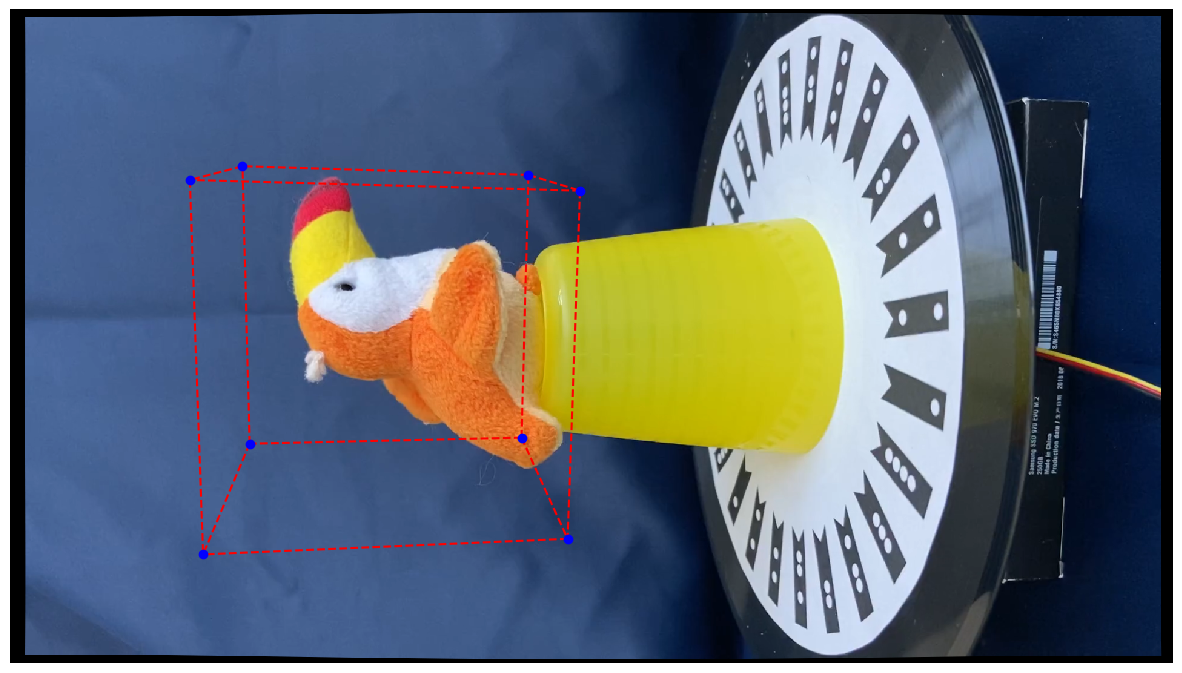

In [35]:
# create object video
video = VideoReader(FOLDER, VIDEO, K, distortion)
plt.figure(figsize=(15, 10))
I_undistort = video.get_actual_frame(color=True)
plt.imshow(I_undistort, interpolation="none")
plt.axis("off")
# compute cube points
pixel_points = compute_cube(polygon_list, angle_list, K, distortion, height_start=85., dim_l=70., ad_x=1150.)
# DRAW PHASE
# draw lines
# lower square
plt.plot(pixel_points[:2, 0], pixel_points[:2, 1], color="red", linestyle="--")
plt.plot(pixel_points[1:3, 0], pixel_points[1:3, 1], color="red", linestyle="--")
plt.plot(pixel_points[2:4, 0], pixel_points[2:4, 1], color="red", linestyle="--")
plt.plot(pixel_points[[0,3], 0], pixel_points[[0,3], 1], color="red", linestyle="--")
# upper square
plt.plot(pixel_points[4:6, 0], pixel_points[4:6, 1], color="red", linestyle="--")
plt.plot(pixel_points[5:7, 0], pixel_points[5:7, 1], color="red", linestyle="--")
plt.plot(pixel_points[6:8, 0], pixel_points[6:8, 1], color="red", linestyle="--")
plt.plot(pixel_points[[4,7], 0], pixel_points[[4,7], 1], color="red", linestyle="--")
# join lower and upper part
plt.plot(pixel_points[[0, 4], 0], pixel_points[[0, 4], 1], color="red", linestyle="--")
plt.plot(pixel_points[[1, 5], 0], pixel_points[[1, 5], 1], color="red", linestyle="--")
plt.plot(pixel_points[[2, 6], 0], pixel_points[[2, 6], 1], color="red", linestyle="--")
plt.plot(pixel_points[[3,7], 0], pixel_points[[3,7], 1], color="red", linestyle="--")
# draw verteces
for p in pixel_points:
    plt.plot(p[0], p[1], marker="o", color="blue")

### Try over all frames
In function compute_cube the cube_side hyperparameter identify thre real side of cube, since that I used for the vertex always angle of difference of 90°.
So simply from the side I can retrieve the radius to determine the cube from the center and the formula is: side = **radius*sqrt(2)**

#### Functions assignment 3

In [5]:
# find 3D points of markers according to radius and starting angle (z coordinate will be always 0)
def find_3d_points(point_angles, r=70., d_angle=15.):
    # define zero matrix of right dimension
    point_3d = np.zeros((point_angles.shape[0], 3), dtype=np.float32)
    # compute 3d point for each angle
    for i, p_angle in enumerate(point_angles):
        rad = -np.radians(p_angle*d_angle)
        point_3d[i, :2] = [np.cos(rad)*r, np.sin(rad)*r]
    return point_3d   

# convert rotation vector and translation vector to 4x4 matrix
def rtvec_to_matrix(rvec, tvec):
	T = np.eye(4)
    # convert rotation vector to rotation matrix
	R, _ = cv.Rodrigues(rvec)
	T[:3, :3] = R
	T[:3, 3] = tvec.squeeze()
	return T

# determine 2d and 3d points to fill solvePnp
def find_points_for_PnP(polygon_list, angle_list, npoints=3, origin=np.array([[160, 540]], dtype=np.float32)):
    # determine which markers will be used to determine rotation and translation vector
    marker_to_use = None
    # determine the positions of markers in array
    position_of_marker_to_use = None
    # take only the concave vertex for each polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[npoints-1::npoints] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // npoints, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to start_point(cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # determine central marker
    central_marker = angle_list[actual_pos]
    # determine below markers
    marker_to_use = np.array([i%24 for i in np.arange(central_marker+1, central_marker+1+5, 1)])
    # determine above markers
    marker_to_use = np.concatenate((marker_to_use, np.array([i%24 for i in np.arange(central_marker-1, central_marker-1-5, -1)]), np.array([central_marker])), axis=0)
    # vector used to discover real position of markers
    bool_vector = np.zeros(angle_list.shape[0], dtype=bool)
    # define a vector of bool where there are True in marker_to_use positions
    for m in marker_to_use:
        bool_vector += angle_list == m
    # return polygons of that markers
    select_polygons = polygon_list.reshape((polygon_list.shape[0] // npoints, npoints, 2))[np.where(bool_vector)[0]]
    # from each polygon extract only concave vertex
    point_2d = select_polygons[:, npoints-1, :].copy()
    # extract right marker for each extracted vertex
    angle_2d = angle_list[np.where(bool_vector)[0]]
    # determine 3d points using markers
    point_3d = find_3d_points(angle_2d)
    return point_3d, point_2d

# compute rotation and translation matrix
def compute_RT_matrix(polygon_list, angle_list, K, distortion, use_distortion=False):
    # determine points for solvePnP
    point_3d, point_2d = find_points_for_PnP(polygon_list, angle_list)
    if use_distortion:
        # find rotation and translation vectors
        ret, R, T = cv.solvePnP(point_3d, point_2d, K, distortion, flags=cv.SOLVEPNP_IPPE)
    else:
        # find rotation and translation vectors
        ret, R, T = cv.solvePnP(point_3d, point_2d, K, None, flags=cv.SOLVEPNP_IPPE)
    # find rotation translation matrix
    RT_mat = rtvec_to_matrix(R, T)
    return RT_mat

# determine verteces of cube
def compute_cube(angle_list, K, RT_mat, height_start=0., cube_side=80.):
    radius = cube_side / np.sqrt(2)
    # marker at which I want to put the verteces of cube
    angle_corner = np.array([ 0.,  6., 12., 18.], dtype=np.float32)
    # lower corners of cube
    lower_corners = find_3d_points(angle_corner, r=radius)
    # transform in homogeneous coordinate
    lower_corners = np.concatenate((lower_corners, np.ones(lower_corners.shape[0]).reshape(-1, 1)), axis=1)
    # add height
    lower_corners[:, 2] = height_start
    # upper corners of cube
    upper_corners = lower_corners.copy()
    # add height (equal to distance between 2 verteces)
    upper_corners[:, 2] += cube_side
    # matrix of corners in world coordinates
    corners_3d = np.concatenate((lower_corners, upper_corners))
    # compute homogeneous 2d coordinates
    corners_2d = K.dot(RT_mat.dot(corners_3d.T)[:-1]).T
    # compute inhomogeneous coordinates
    corners_2d = np.apply_along_axis(lambda x: x[:2] / x[2], 1, corners_2d)
    return corners_2d

# compute axis points
def compute_axis(angle_list, K, RT_mat, lenght_axes=40.):
    # marker at which I want to put the axes x and y
    angle_corner = np.array([ 0.,  6.], dtype=np.float32)
    # create origin
    origin_3d = np.array([[0, 0, 0]], dtype=np.float32)
    # create x and y 3d point
    axis_3d = find_3d_points(angle_corner, r=lenght_axes)
    # concatenate origin with x and y
    axis_3d = np.concatenate((origin_3d, axis_3d))
    # create z 3d point
    axes_z = np.array([[0., 0., lenght_axes]], dtype=np.float32)
    # add z 3d point to axis
    axis_3d = np.concatenate((axis_3d, axes_z))
    # transform 3d point in homogeneous coordinate
    axis_3d = np.concatenate((axis_3d, np.ones(axis_3d.shape[0]).reshape(-1, 1)), axis=1)
    # compute homogeneous 2d coordinates
    axis_2d = K.dot(RT_mat.dot(axis_3d.T)[:-1]).T
    # compute inhomogeneous coordinates
    axis_2d = np.apply_along_axis(lambda x: x[:2] / x[2], 1, axis_2d)
    return axis_2d
    
# adjust axes for polygons
def adj_axis(polygon_list, adj_x=0., adj_y=0.):
    polygon_list_full_image = polygon_list.copy()
    polygon_list_full_image[:, 0] += adj_x
    polygon_list_full_image[:, 1] += adj_y
    return polygon_list_full_image

# plot function
def verbose(polygon_list, angle_list, I, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # define cyclic color
    colors_cycle = ['cyan', 'fuchsia', 'blueviolet']
    plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # reshape to have n polygons x 3 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2)).astype(np.int32)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    # remove axis
    plt.axis('off')
    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x", ms=8, markeredgewidth=.9)
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in ticks:
            # define point
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            # plot it
            plt.plot(point[0], point[1], marker="o", color="lime", ms=1.5)
        # define position of angle label
        text_pos = np.array(mean_point * (1.4) + conc_point * -.4, dtype=np.int32)
        # plot it
        plt.text(text_pos[0], text_pos[1], f"{angle_list[e]}", fontsize=8, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()

# plot function
def verbose_2(angle_list, K, RT_mat, I, height_start=0., cube_side=80., lenght_axes=40.):
    # determine cube verteces
    cube_pixel_points = compute_cube(angle_list, K, RT_mat, height_start, cube_side)
    # determine axis 
    axis_points = compute_axis(angle_list, K, RT_mat, lenght_axes)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    plt.axis("off")
    # DRAW AXIS
    # axes x
    plt.plot(axis_points[:2, 0], axis_points[:2, 1], color="orangered")
    # axes y
    plt.plot(axis_points[[0, 2], 0], axis_points[[0, 2], 1], color="lime")
    # axes z
    plt.plot(axis_points[[0, 3], 0], axis_points[[0, 3], 1], color="dodgerblue")
    # DRAW CUBE
    # draw lines
    # lower square
    plt.plot(cube_pixel_points[:2, 0], cube_pixel_points[:2, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[1:3, 0], cube_pixel_points[1:3, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[2:4, 0], cube_pixel_points[2:4, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[0,3], 0], cube_pixel_points[[0,3], 1], color="red", linestyle="--")
    # upper square
    plt.plot(cube_pixel_points[4:6, 0], cube_pixel_points[4:6, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[5:7, 0], cube_pixel_points[5:7, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[6:8, 0], cube_pixel_points[6:8, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[4,7], 0], cube_pixel_points[[4,7], 1], color="red", linestyle="--")
    # join lower and upper part
    plt.plot(cube_pixel_points[[0, 4], 0], cube_pixel_points[[0, 4], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[1, 5], 0], cube_pixel_points[[1, 5], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[2, 6], 0], cube_pixel_points[[2, 6], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[3,7], 0], cube_pixel_points[[3,7], 1], color="red", linestyle="--")
    # draw verteces
    for p in cube_pixel_points:
        plt.plot(p[0], p[1], marker="o", color="blue")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()  

# plot function
def verbose_cv(polygon_list, angle_list, K, RT_mat, I, height_start=0., cube_side=80., lenght_axes=40., save_video=None, ticks=np.array([0.84, 0.68, 0.52, 0.36, 0.2], dtype=np.float32)):
    # change color of image
    image = cv.cvtColor(I, cv.COLOR_RGB2BGR)
    # PRINT MARKERS
    # reshape to have n polygons x 3 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0] // 3, 3, 2)).astype(np.int32)
    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            image = cv.circle(image, np.around(corner), radius=4, color=(0, 128, 255), thickness=-1)
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in ticks:
            # define point
            point = np.array(mean_point * (1 - q) + conc_point * q, dtype=np.int32)
            # plot it
            image = cv.circle(image, np.around(point), radius=3, color=(0, 204, 0), thickness=-1)
        # define position of angle label
        text_pos = np.array(mean_point * (-.4) + conc_point * 1.4, dtype=np.int32)
        # plot it
        image = cv.putText(image, f'{angle_list[e]}', np.around(text_pos), cv.FONT_HERSHEY_SIMPLEX,
                           1, (255, 0, 255), 1, cv.LINE_AA)
    # PRINT CUBE AND AXIS
    # determine cube verteces
    cube_pixel_points = compute_cube(angle_list, K, RT_mat, height_start, cube_side)
    # round to int
    cube_pixel_points = np.around(cube_pixel_points).astype(np.int32)
    # determine axis
    axis_points = compute_axis(angle_list, K, RT_mat, lenght_axes)
    # round to int
    axis_points = np.around(axis_points).astype(np.int32)
    # DRAW AXIS
    # axes x
    image = cv.line(image, axis_points[0, :], axis_points[1, :], (255, 0, 0), 3)
    # axes y
    image = cv.line(image, axis_points[0, :], axis_points[2, :], (0, 255, 0), 3)
    # axes z
    image = cv.line(image, axis_points[0, :], axis_points[3, :], (0, 0, 255), 3)
    # DRAW CUBE
    # draw lines
    # lower square
    image = cv.line(image, cube_pixel_points[0, :], cube_pixel_points[1, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[1, :], cube_pixel_points[2, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[2, :], cube_pixel_points[3, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[0, :], cube_pixel_points[3, :], (255, 0, 0), 3)
    # upper square
    image = cv.line(image, cube_pixel_points[4, :], cube_pixel_points[5, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[5, :], cube_pixel_points[6, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[6, :], cube_pixel_points[7, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[4, :], cube_pixel_points[7, :], (255, 0, 0), 3)
    # join lower and upper part
    image = cv.line(image, cube_pixel_points[0, :], cube_pixel_points[4, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[1, :], cube_pixel_points[5, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[2, :], cube_pixel_points[6, :], (255, 0, 0), 3)
    image = cv.line(image, cube_pixel_points[3, :], cube_pixel_points[7, :], (255, 0, 0), 3)

    if save_video:
        save_video.write(image)
    else:
        # define size of window
        cv.namedWindow("Video", cv.WINDOW_NORMAL)
        cv.resizeWindow("Video", 900, 900)
        # print image
        cv.imshow("Video", image)

    key = cv.waitKey(10)
    if key == 27:
        cv.destroyWindow("Video")
        return True
    else:
        return False

#### Code

In [6]:
# intrinsic camera parameter
K = np.array([[1.66713324e+03, 0.00000000e+00, 9.51137528e+02],
              [0.00000000e+00, 1.66954293e+03, 5.29018205e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=np.float32)
# distorsion parameter
distortion = np.array([[1.13913462e-01, -2.75143257e-02,  3.39404705e-04, -2.42018474e-03, -6.13191579e-01]], dtype=np.float32)

In [7]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

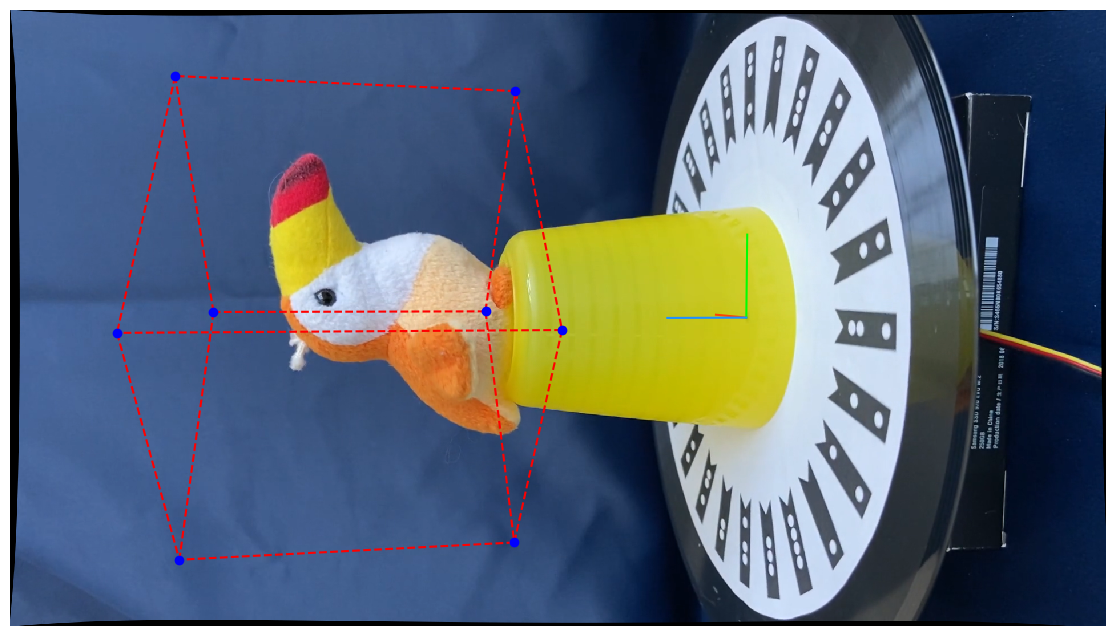

In [8]:
# create object video
video = VideoReader(FOLDER, VIDEO, K, distortion, initial_frame=40)

# take frame (reduce dimension of frame)
I_g = video.get_actual_frame([1150, 1590])
# extract polygons from image
polygon_list = find_polygons_LK(I_g)
# for each polygon extract only 3 points (the 2 most distance form origin and the concave vertex)
polygon_list = find_important_points_LK(polygon_list)
# determine angles
angle_list = find_angle_list_LK(I_g, polygon_list)
# set old image and old polygons
I_g_old = I_g
polygon_list_old = polygon_list

# go to next frame
video.next_frame()

while not video.is_finished():
    # take actual frame
    I_g = video.get_actual_frame([1150, 1590])
    # compute polygons (each 20 iterations I compute a full ispection to have a better result)
    if not(video.get_frame_id() % 20 == 0):
        # LK flow
        polygon_list, status, error = optical_flow(I_g_old, I_g, polygon_list_old)
        # remove polygons no longer in right domain for viewer
        polygon_list, l_del = check_right_polygons_LK(polygon_list, n_points=3)
        # remove angles of polygons no longer in right domain for viewer
        angle_list = np.delete(angle_list, l_del, axis=0)
        # increment precision of points for each polygon
        polygon_list = find_more_accurate_points_LK(I_g, polygon_list, n_points=3)
    # refresh
    else:
        # find polygons
        polygon_list = find_polygons_LK(I_g)
        # extact only important points for each polygon (concave vertex, the 2 most distance points from "origin")
        polygon_list = find_important_points_LK(polygon_list)
        # define angle list
        angle_list = find_angle_list_LK(I_g, polygon_list)
        
    # set old image and old polygons
    I_g_old = I_g
    polygon_list_old = polygon_list
    
    # adjust x axes to bring all polygons in full image
    polygon_list_adj = adj_axis(polygon_list, adj_x=1150.)
    # compute rotation translation matrix
    RT_mat = compute_RT_matrix(polygon_list_adj, angle_list, K, distortion)
    
    # plot 
#     verbose(polygon_list_adj, angle_list, video.get_actual_frame(color=True))
    verbose_2(angle_list, K, RT_mat, video.get_actual_frame(color=True), height_start=85, cube_side=110, lenght_axes=30)
#     if verbose_cv(polygon_list_adj, angle_list, video.get_actual_frame(color=True), height_start=85, cube_side=100, lenght_axes=30):
#         break
    # next frame
    video.next_frame()
    break

# release video
video.release()


## Determine voxel
To make a simpler voxel I decided to translate the verteces of cube from angles 0°, 90°, 180°, 270°
to angles 45°, 135°, 225°, 315° in this way I have an oriented cube to compute mash grid in easy way.
<img src="./Images/rotation_idea.jpg" width="300px" height="auto" />
NB: I used the advice given from professor, i.e. use the undistort image for all process.

### Functions assignment 1

In [6]:
# correction of gamma
def gammaCorrection(I, G=1.):
    invG = 1/G
    table = [((i/255)**invG)*255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv.LUT(I, table)

# Euclidean distance for standardized color coordinate in YUV color space
def chroma_distance_ED(UV, u, v):
    return np.sqrt((UV[:,:,0] - u)**2 + (UV[:,:,1] - v)**2)

# create mask for standardized color coordinate in YUV color space
def create_mask(UV_image, u_center, v_center, max_dist_foreground, f_distance, foreground_from_x=None, background_to_x=None):
    if foreground_from_x is None:
        foreground_from_x = UV_image.shape[1]
    if background_to_x is None:
        background_to_x = 0
    # mask composes only by ones
    mask = np.ones(UV_image.shape[:2])        
    # create mask
    mask[:, :(foreground_from_x + 1)] = f_distance(UV_image[:, :(foreground_from_x + 1), :], u_center, v_center) > max_dist_foreground
    # add constant background
    mask[:, 0:(background_to_x + 1)] = 0
    return mask   

# determine silouette of the object
def determine_silouette(I, apply_closing=False):
    # used to solve problem of darkness
    I = gammaCorrection(I, G=2.5)
    # used to solve problem of hairs on object
    I = cv.blur(I, (15, 15))
    # convert from RGB to YUV space color
    I_yuv = cv.cvtColor(I, cv.COLOR_RGB2YUV)
    # Normalize UV channels between [-0.5; 0.5]
    UV = I_yuv[:,:,1:3] / 255. - .5
    # create mask
    mask = create_mask(UV, 0.275, -0.275, 0.31819805, chroma_distance_ED, 1300, 400)
    # apply closing
    if apply_closing:
        # kernel for closing
        kernel_C = np.ones((47, 47), np.uint8)
        # I don't apply opening otherwise the hole will re open and to use both open and close
        # I should increase the kernel size of closing, and this brings me to a worse silouette
        # apply closing to close the hole
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel_C)
    return mask

### Functions assignment 2

In [7]:
class VideoReader(cv.VideoCapture):
    def __init__(self, folder, video, K, distortion, initial_frame=0):
        super().__init__(folder + video)
        self.actual_frame = initial_frame
        self.total_frames = self.get(cv.CAP_PROP_FRAME_COUNT)
        self.K = K
        self.distortion = distortion

    def get_actual_frame(self, shape=None, color=False, undistort=True):
        self.set(cv.CAP_PROP_POS_FRAMES, self.actual_frame)
        _, I = self.read()
        if color == 1:
            I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
        elif color == 0:
            I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        # undistortion 
        if undistort:
            I = cv.undistort(I, self.K, self.distortion, None)
        # catch only a subset of image
        if shape:
            I = I[:, shape[0]:shape[1]]
        return I
    
    def get_frame_id(self):
        return self.actual_frame
    
    def next_frame(self, plus_n=1):
        self.actual_frame += plus_n
    
    def is_finished(self):
        return not self.actual_frame < self.total_frames

In [8]:
# find polygons
def find_polygons_LK(I_g):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # find only polygons
    polygon_list = []
    # for each contour search polygon
    for contours_area in contours:
        polygon_perimeter = cv.arcLength(contours_area, True)
        epsilon1 = 0.010 * polygon_perimeter
        epsilon2 = 0.017 * polygon_perimeter
        # find approx poly for the only one contour present in this image
        approx_polygon1 = cv.approxPolyDP(contours_area, epsilon1, True)
        approx_polygon2 = cv.approxPolyDP(contours_area, epsilon2, True)
        # store only polygons with 5 vertexes
        if len(approx_polygon2) == 5 and is_in_mean(approx_polygon2):
            polygon_list.append(approx_polygon)
        elif len(approx_polygon1) == 5 and is_in_mean(approx_polygon1):
            polygon_list.append(approx_polygon1)
    # transform in numpy
    polygon_list = np.array(polygon_list, dtype=np.float32)
    # reshape in this way I already have the right format for LK algorithm
    polygon_list = polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2))
    # refine polygons vertices
    accurated_polygon_list = find_more_accurate_points_LK(I_g, polygon_list)
    return accurated_polygon_list
    
# remove polygons that doesn't belong to the bell curve
def is_in_mean_LK(appr_polygon, mean=373.4330426322089, std_dev=57.201333239224326):
    low_bound = mean - 2.3*std_dev
    high_bound = mean + 2.3*std_dev
    return True if low_bound <= cv.arcLength(appr_polygon, True) <= high_bound else False

# increment precision of vertices for each polygon
# this is an improvement, need to have a better corner in all image
def find_more_accurate_points_LK(I_g, polygons, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 200, 0.0001), division=150, n_points=5):
    # in order to return the polygon_list with the same order of the input list
    maintain_order = np.arange(0, polygons.shape[0] // n_points, 1)
    # create condition (get casual corner in each polygon)
    # because at the border of circle polygons are smaller, 
    # so I prefer to split in order to have a better result.
    condition = polygons[::n_points, 0] < division
    # split polygons that meet condition
    maintain_order_1 = maintain_order[condition]
    polygons_1 = polygons.reshape((polygons.shape[0] // n_points, n_points, 2))[condition, :, :]
    polygons_1 = polygons_1.reshape((polygons_1.shape[0] * polygons_1.shape[1], 2))
    # split polygons that don't meet condition
    maintain_order_2 = maintain_order[~condition]
    polygons_2 = polygons.reshape((polygons.shape[0] // n_points, n_points, 2))[~condition, :, :]
    polygons_2 = polygons_2.reshape((polygons_2.shape[0] * polygons_2.shape[1], 2))
    # determine better corners for each polygon
    better_polygons_1 = cv.cornerSubPix(I_g, polygons_1, (4,4), (-1,-1), criteria)
    better_polygons_2 = cv.cornerSubPix(I_g, polygons_2, (6,6), (-1,-1), criteria)
    # append the 2 matrix
    better_polygons = np.append(better_polygons_1, better_polygons_2, axis=0)
    # find the right permutation of better_polygons to have the same order of input
    right_position = np.argsort(np.concatenate((maintain_order_1, maintain_order_2)))
    # compute permutation
    shuffled_better_polygons = better_polygons.reshape(better_polygons.shape[0] // n_points, n_points, 2)[right_position, :, :]
    return shuffled_better_polygons.reshape(shuffled_better_polygons.shape[0]*n_points, 2)

# remove polygons that are to close to the cup (lower part of image)
# return right polygons and the position of removed polygons
def check_right_polygons_LK(polygons, n_points=5):
    polygon_list = polygons.reshape((polygons.shape[0]//n_points, n_points, 2))
    # position of removed polygons
    l_del = []
    # find which polygon doesn't respect the rule
    for e, poly in enumerate(polygon_list):
        if not is_in_domain_LK(poly):
            l_del.append(e)
    # delete polygons that don't respect the rule
    polygon_list = np.delete(polygon_list, l_del, axis=0)
    return polygon_list.reshape((polygon_list.shape[0]*polygon_list.shape[1], 2)), l_del
    
# return False if polygons is in dubious position (near the cup)
def is_in_domain_LK(appr_polygon, above=270, below=820, origin=np.array([160, 540])):
    points_distance = np.linalg.norm(origin - appr_polygon, axis=1)
    # arg sort of points
    arg_sort_points = np.argsort(points_distance)
    # the 2 most distance points from origin
    points = appr_polygon[[arg_sort_points[-1], arg_sort_points[-2]]]
    if any(points[:, 1] > above) and any(points[:, 1] < below) and any(points[:, 0] < origin[0]):
        return False
    else:
        return True

# return only interesting points for each polygon.
# Determine the 2 most distance points from origin and the concave vertex
# From 5 points for each polygon this algorithm returns 3 points
def find_important_points_LK(polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=5):
    # compute distance for each point from origin
    points_distance = np.linalg.norm(origin - polygon_list, axis=1)
    # reshape to create n polygons x 5
    polygon_distance = points_distance.reshape((points_distance.shape[0] // npoints, npoints))
    # find the argsort for each point of each polygon
    argsort_points = np.argsort(polygon_distance, axis=1)
    # trasform list of point in n polygons x 5 x 2 to extract only important point
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//npoints, npoints, 2))
    imp_point_list = []
    for i in range(polygon_list.shape[0]):
        # the 2 most distance point from origin
        d_points = polygon_list[i, argsort_points[i, :2:-1]]
        # mean between points
        d_mean = d_points.mean(axis=0)
        # remaining 3 points
        remain_points = polygon_list[i, argsort_points[i, :3]]
        # compute distance from the point d_mean
        remain_distance = np.linalg.norm(d_mean - remain_points, axis=1)
        # this point is the closest point to d_mean (concave vertex)
        v_point = remain_points[np.argmin(remain_distance)]
        # reshape to compute append
        v_point = v_point.reshape(1, 2)
        # aggregate all importan point for polygon
        imp_point_polygon = np.append(d_points, v_point, axis=0)
        imp_point_list.append(imp_point_polygon)
    return np.array(imp_point_list, dtype=np.float32).reshape(len(imp_point_list)*3, 2)

# find angle for a polygon
def find_angle_LK(thresh, poly, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # mean between the 2 most distance points from origin
    mean_point = poly[:2].mean(axis=0)
    # concave point
    conc_point = poly[-1]
    # determine position
    pos = 0
    # it starts from inner to outer
    for e, q in enumerate(ticks):
        # determine position
        point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
        # if the pixel is close to white I count, because the treshold image is reversed
        if thresh[point[1], point[0]] > 0:
            pos += 2**e
    return pos

# find the angle of each polygon
# idea: compute the angle of central polygon and define the other angles simple with a +1 or -1
def find_angle_list_LK(I_g, polygon_list, origin=np.array([[160, 540]], dtype=np.float32), npoints=3):
    # apply blur but maintaining edges
    I_g = cv.bilateralFilter(I_g,  d=17, sigmaColor=1, sigmaSpace=2)
    # apply threshold and use inverse as color
    _, thresh = cv.threshold(I_g, 150, 255, cv.THRESH_BINARY_INV)
    # array of True (maintain the corrispondence between element that I have already seen)
    boolean_list = np.ones((polygon_list.shape[0] // npoints), dtype=bool)
    # maintain the corrispondence
    corrispondence_list = np.arange(0, polygon_list.shape[0] // npoints, 1)
    # list of angles
    angle_list = np.zeros((polygon_list.shape[0] // npoints), dtype=np.int16)
    # take only the concave vertex for ea-ch polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[npoints-1::npoints] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // npoints, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to start_point(cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # central polygon, the best polygon to define angle
    central_poly = polygon_list.reshape(polygon_list.shape[0] // npoints, npoints, 2)[actual_pos]
    # determine angle of central polygon
    angle_list[actual_pos] = find_angle_LK(thresh, central_poly)
    # extract vector
    actual_point = normalized_points[actual_pos, :]
    # remove actual location from normalized_points
    normalized_points = np.delete(normalized_points, actual_pos, axis=0)
    # set a False the position 
    boolean_list[corrispondence_list[boolean_list][actual_pos]] = False
    # find the 2 closest point from the actual point
    # in this way in iterative way I can go up using a point and down using the other point
    # to have a consistent labels for each polygon
    central_points_pos = np.argsort(normalized_points.dot(actual_point))[::-1][:2]
    above_point, below_point = None, None
    above_pos, below_pos = None, None
    if points[corrispondence_list[boolean_list][central_points_pos[0]]][1] < points[actual_pos][1]:
        # position in matrix
        above_pos = central_points_pos[0]
        # position in matrix
        below_pos = central_points_pos[1]
    else:
        # position in matrix
        above_pos = central_points_pos[1]
        # position in matrix
        below_pos = central_points_pos[0]
    # extract point
    above_point = normalized_points[above_pos, :]
    # real position inside angle list
    above_pos = corrispondence_list[boolean_list][above_pos]
    # extract point
    below_point = normalized_points[below_pos, :]
    # real position inside angle list
    below_pos = corrispondence_list[boolean_list][below_pos] 
    # put the right angle value
    angle_list[above_pos] = (24 + (angle_list[actual_pos] - 1)) % 24
    angle_list[below_pos] = (24 + (angle_list[actual_pos] + 1)) % 24
    # remove actual location
    normalized_points = np.delete(normalized_points, central_points_pos, axis=0)
    # set a False the positions 
    boolean_list[corrispondence_list[boolean_list][central_points_pos]] = False
    # counter to meet exit condition
    count = 1
    # condition to exit is when inside normalized_points there is only one point
    # -3 because I have already processed 3 points
    while count < (boolean_list.shape[0] - 3):
        # above
        if count % 2 == 0:
            # the closest point to above_point
            new_pos = np.argsort(normalized_points.dot(above_point))[-1]
            # set new above point
            above_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[above_pos] - 1)) % 24
            # real position inside angle list
            above_pos = corrispondence_list[boolean_list][new_pos]
        # below
        else:    
            # the closest point to below_point
            new_pos = np.argsort(normalized_points.dot(below_point))[-1]
            # set new below point
            below_point = normalized_points[new_pos, :]
            # temporal real pos
            tmp_real_pos = corrispondence_list[boolean_list][new_pos]
            # modify angle
            angle_list[tmp_real_pos] = (24 + (angle_list[below_pos] + 1)) % 24
            # real position inside angle list
            below_pos = corrispondence_list[boolean_list][new_pos]
        # remove actual location
        normalized_points = np.delete(normalized_points, new_pos, axis=0)
        # set a False the positions 
        boolean_list[corrispondence_list[boolean_list][new_pos]] = False
        count += 1    
    # find at which between above and below the last polygon is closed
    m = np.append(above_point.reshape((1,2)), below_point.reshape((1,2)), axis=0)
    closer_to_pos = np.argmax(m.dot(normalized_points.T))
    if closer_to_pos == 0:
        angle_list[boolean_list] = (24 + (angle_list[above_pos] - 1)) % 24
    else:
        angle_list[boolean_list] = (24 + (angle_list[below_pos] + 1)) % 24
    return angle_list

# apply optical flow
def optical_flow(I_g_old, I_g, polygon_list_old):
    # criteria for Lucas Kanade
    lk_params = dict(winSize=(10, 10),
                     maxLevel=2,
                     criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 50, 0.003)) 
    return cv.calcOpticalFlowPyrLK(I_g_old, I_g, polygon_list_old, None, **lk_params)

# plot function
def verbose(polygon_list, angle_list, I, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # define cyclic color
    colors_cycle = ['cyan', 'fuchsia', 'blueviolet']
    plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # reshape to have n polygons x 3 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2)).astype(np.int32)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    # remove axis
    plt.axis('off')
    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x", ms=8, markeredgewidth=.9)
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in ticks:
            # define point
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            # plot it
            plt.plot(point[0], point[1], marker="o", color="lime", ms=1.5)
        # define position of angle label
        text_pos = np.array(mean_point * (1.4) + conc_point * -.4, dtype=np.int32)
        # plot it
        plt.text(text_pos[0], text_pos[1], f"{angle_list[e]}", fontsize=8, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()

### Functions assignment 3

In [2]:
# find 3D points of markers according to radius and starting angle (z coordinate will be always 0)
def find_3d_points(point_angles, r=70., d_angle=15.):
    # define zero matrix of right dimension
    point_3d = np.zeros((point_angles.shape[0], 3), dtype=np.float32)
    # compute 3d point for each angle
    for i, p_angle in enumerate(point_angles):
        rad = -np.radians(p_angle*d_angle)
        point_3d[i, :2] = [np.cos(rad)*r, np.sin(rad)*r]
    return point_3d   

# convert rotation vector and translation vector to 4x4 matrix
def rtvec_to_matrix(rvec, tvec):
	T = np.eye(4)
    # convert rotation vector to rotation matrix
	R, _ = cv.Rodrigues(rvec)
	T[:3, :3] = R
	T[:3, 3] = tvec.squeeze()
	return T

# determine 2d and 3d points to fill solvePnp
def find_points_for_PnP(polygon_list, angle_list, npoints=3, origin=np.array([[160, 540]], dtype=np.float32)):
    # determine which markers will be used to determine rotation and translation vector
    marker_to_use = None
    # determine the positions of markers in array
    position_of_marker_to_use = None
    # take only the concave vertex for each polygon and subtract origin
    # in order to shift the center from the left corner to the origin
    points = polygon_list[npoints-1::npoints] - origin
    # compute l2 norm for each point
    norm = np.linalg.norm(points, axis=1).reshape(polygon_list.shape[0] // npoints, 1)
    # normalize each vector
    normalized_points = np.divide(points, norm)
    # horizontal point respect to the new origin
    # is the location where the angle is surely correct
    start_point = np.array([1, 0], dtype=np.float32)
    # find the closest to start_point(cosine similarity)(in the center of image)
    actual_pos = np.argmax(normalized_points.dot(start_point))
    # determine central marker
    central_marker = angle_list[actual_pos]
    # determine below markers
    marker_to_use = np.array([i%24 for i in np.arange(central_marker+1, central_marker+1+5, 1)])
    # determine above markers
    marker_to_use = np.concatenate((marker_to_use, np.array([i%24 for i in np.arange(central_marker-1, central_marker-1-5, -1)]), np.array([central_marker])), axis=0)
    # vector used to discover real position of markers
    bool_vector = np.zeros(angle_list.shape[0], dtype=bool)
    # define a vector of bool where there are True in marker_to_use positions
    for m in marker_to_use:
        bool_vector += angle_list == m
    # return polygons of that markers
    select_polygons = polygon_list.reshape((polygon_list.shape[0] // npoints, npoints, 2))[np.where(bool_vector)[0]]
    # from each polygon extract only concave vertex
    point_2d = select_polygons[:, npoints-1, :].copy()
    # extract right marker for each extracted vertex
    angle_2d = angle_list[np.where(bool_vector)[0]]
    # determine 3d points using markers
    point_3d = find_3d_points(angle_2d)
    return point_3d, point_2d

# compute rotation and translation matrix
def compute_RT_matrix(polygon_list, angle_list, K, distortion, use_distortion=False):
    # determine points for solvePnP
    point_3d, point_2d = find_points_for_PnP(polygon_list, angle_list)
    if use_distortion:
        # find rotation and translation vectors
        ret, R, T = cv.solvePnP(point_3d, point_2d, K, distortion, flags=cv.SOLVEPNP_IPPE)
    else:
        # find rotation and translation vectors
        ret, R, T = cv.solvePnP(point_3d, point_2d, K, None, flags=cv.SOLVEPNP_IPPE)
    # find rotation translation matrix
    RT_mat = rtvec_to_matrix(R, T)
    return RT_mat

# determine verteces of cube
def compute_cube(angle_list, K, RT_mat, height_start=0., cube_side=80.):
    radius = cube_side / np.sqrt(2)
    # marker at which I want to put the verteces of cube
    angle_corner = np.array([ 3.,  9., 15., 21.], dtype=np.float32)
    # lower corners of cube
    lower_corners = find_3d_points(angle_corner, r=radius)
    # transform in homogeneous coordinate
    lower_corners = np.concatenate((lower_corners, np.ones(lower_corners.shape[0]).reshape(-1, 1)), axis=1)
    # add height
    lower_corners[:, 2] = height_start
    # upper corners of cube
    upper_corners = lower_corners.copy()
    # add height (equal to distance between 2 verteces)
    upper_corners[:, 2] += cube_side
    # matrix of corners in world coordinates
    corners_3d = np.concatenate((lower_corners, upper_corners))
    # compute homogeneous 2d coordinates
    corners_2d = K.dot(RT_mat.dot(corners_3d.T)[:-1]).T
    # compute inhomogeneous coordinates
    corners_2d = np.apply_along_axis(lambda x: x[:2] / x[2], 1, corners_2d)
    return corners_2d

# compute axis points
def compute_axis(angle_list, K, RT_mat, lenght_axes=40.):
    # marker at which I want to put the axes x and y
    angle_corner = np.array([ 0.,  6.], dtype=np.float32)
    # create origin
    origin_3d = np.array([[0, 0, 0]], dtype=np.float32)
    # create x and y 3d point
    axis_3d = find_3d_points(angle_corner, r=lenght_axes)
    # concatenate origin with x and y
    axis_3d = np.concatenate((origin_3d, axis_3d))
    # create z 3d point
    axes_z = np.array([[0., 0., lenght_axes]], dtype=np.float32)
    # add z 3d point to axis
    axis_3d = np.concatenate((axis_3d, axes_z))
    # transform 3d point in homogeneous coordinate
    axis_3d = np.concatenate((axis_3d, np.ones(axis_3d.shape[0]).reshape(-1, 1)), axis=1)
    # compute homogeneous 2d coordinates
    axis_2d = K.dot(RT_mat.dot(axis_3d.T)[:-1]).T
    # compute inhomogeneous coordinates
    axis_2d = np.apply_along_axis(lambda x: x[:2] / x[2], 1, axis_2d)
    return axis_2d
    
# adjust axes for polygons
def adj_axis(polygon_list, adj_x=0., adj_y=0.):
    polygon_list_full_image = polygon_list.copy()
    polygon_list_full_image[:, 0] += adj_x
    polygon_list_full_image[:, 1] += adj_y
    return polygon_list_full_image

# plot function
def verbose(polygon_list, angle_list, I, ticks=np.array([0.84, 0.68, 0.52,0.36, 0.2], dtype=np.float32)):
    # define cyclic color
    colors_cycle = ['cyan', 'fuchsia', 'blueviolet']
    plt.rcParams["axes.prop_cycle"] = plt.cycler('color', colors_cycle)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # reshape to have n polygons x 3 x 2
    polygon_list = polygon_list.reshape((polygon_list.shape[0]//3, 3, 2)).astype(np.int32)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    # remove axis
    plt.axis('off')
    # plot corners of polygon
    for e, poly in enumerate(polygon_list):
        for corner in poly:
            plt.plot(corner[0], corner[1], marker="x", ms=8, markeredgewidth=.9)
        # mean between the 2 most distance points froom origin
        mean_point = poly[:2].mean(axis=0)
        # concave point
        conc_point = poly[-1]
        # it starts from inner to outer
        for q in ticks:
            # define point
            point = np.array(mean_point * (1-q) + conc_point * q, dtype=np.int32)
            # plot it
            plt.plot(point[0], point[1], marker="o", color="lime", ms=1.5)
        # define position of angle label
        text_pos = np.array(mean_point * (1.4) + conc_point * -.4, dtype=np.int32)
        # plot it
        plt.text(text_pos[0], text_pos[1], f"{angle_list[e]}", fontsize=8, color="red", bbox=dict(boxstyle="round", fc=(1., 0.8, 0.8)), fontname="Comic Sans MS")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()

# plot function
def verbose_2(angle_list, K, RT_mat, I, height_start=0., cube_side=80., lenght_axes=40.):
    # determine cube verteces
    cube_pixel_points = compute_cube(angle_list, K, RT_mat, height_start, cube_side)
    # determine axis 
    axis_points = compute_axis(angle_list, K, RT_mat, lenght_axes)
    # clear plot of previous frame
    display.clear_output(wait=True)
    # define dim of image
    plt.figure(figsize=(15, 8))
    # plot image
    plt.imshow(I, interpolation="none")
    plt.axis("off")
    # DRAW AXIS
    # axes x
    plt.plot(axis_points[:2, 0], axis_points[:2, 1], color="orangered")
    # axes y
    plt.plot(axis_points[[0, 2], 0], axis_points[[0, 2], 1], color="lime")
    # axes z
    plt.plot(axis_points[[0, 3], 0], axis_points[[0, 3], 1], color="dodgerblue")
    # DRAW CUBE
    # draw lines
    # lower square
    plt.plot(cube_pixel_points[:2, 0], cube_pixel_points[:2, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[1:3, 0], cube_pixel_points[1:3, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[2:4, 0], cube_pixel_points[2:4, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[0,3], 0], cube_pixel_points[[0,3], 1], color="red", linestyle="--")
    # upper square
    plt.plot(cube_pixel_points[4:6, 0], cube_pixel_points[4:6, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[5:7, 0], cube_pixel_points[5:7, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[6:8, 0], cube_pixel_points[6:8, 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[4,7], 0], cube_pixel_points[[4,7], 1], color="red", linestyle="--")
    # join lower and upper part
    plt.plot(cube_pixel_points[[0, 4], 0], cube_pixel_points[[0, 4], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[1, 5], 0], cube_pixel_points[[1, 5], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[2, 6], 0], cube_pixel_points[[2, 6], 1], color="red", linestyle="--")
    plt.plot(cube_pixel_points[[3,7], 0], cube_pixel_points[[3,7], 1], color="red", linestyle="--")
    # draw verteces
    for p in cube_pixel_points:
        plt.plot(p[0], p[1], marker="o", color="blue")
    # get current figure and display it
    display.display(plt.gcf())
    # close figure
    plt.close()  
    
# determine 3d grid in homogeneous coordinates
def compute_grid_3D(height_start=0., cube_side=80., n_voxel=100.):
    # determine x, y, and z coordinates
    x = np.arange(-cube_side/2, cube_side/2, cube_side/n_voxel)
    y = x.copy()
    z = np.arange(height_start, height_start + cube_side, cube_side/n_voxel)
    # determine mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(x, y, z)
    # from mesh determine 3D homogeneous coordinates
    grid_3d = np.array([[a2, b2, c2, 1] for a, b, c in zip(x_mesh, y_mesh, z_mesh) for a1, b1, c1 in zip(a, b, c) for a2, b2, c2 in zip(a1, b1, c1)], dtype=np.float32)
    return grid_3d

# determine 2d grid in inhomogenoeus coordinates
def compute_grid_2D(grid_3d, K, RT_mat):
    # compute 2D homogeneous coordinates
    grid_2d = K.dot(RT_mat.dot(grid_3d.T)[:-1]).T
    # compute inhomogeneous coordinates and cast to int
    grid_2d = np.around(np.apply_along_axis(lambda x: x[:2] / x[2], 1, grid_2d)).astype(np.int32)
    return grid_2d

# filter grid removing element outside the silouette
def filter_grid_3D(grid_3d, grid_2d, silouette, over=0):
    # determine vector of bool
    condition = silouette[grid_2d[:, 1], grid_2d[:, 0]] > 0
    # filter
    grid_3d = grid_3d[condition]
    return grid_3d

# create ply file
def create_ply_file(grid_3d, obj_name, name_file):
    # remove 4° coordinate
    grid_3d = grid_3d[:, :-1]
    # DETERMINE VERTECES
    # determine half length voxel
    hlv = np.linalg.norm(grid_3d[0] - grid_3d[1]) / 2.
    # matrix to find all verteces of voxel (in a specific order)
    find_vertex_voxel = np.array([[-hlv, -hlv, -hlv], [-hlv, -hlv, hlv], [-hlv, hlv, hlv], [-hlv, hlv, -hlv],
                                  [hlv, -hlv, -hlv], [hlv, -hlv, hlv], [hlv, hlv, hlv], [hlv, hlv, -hlv]], dtype=np.float32)
    # for each voxel determine all vertices
    all_verteces = np.apply_along_axis(lambda x : x + find_vertex_voxel, 1, grid_3d)
    # reshape
    all_verteces = all_verteces.reshape((-1, 3))
    # DETERMINE ORDER OF VERTECES TO DEFINE CUBES
    # given a cube this is the order of vertices to create a cube in ply
    indeces_faces = np.array([[0, 1, 2, 3], [7, 6, 5, 4], [0, 4, 5, 1], [1, 5, 6, 2], [2, 6, 7, 3], [3, 7, 4, 0]])
    # create n indeces_faces where n is the number of cube
    el_face = np.tile(indeces_faces, (grid_3d.shape[0], 1))
    # reshape
    el_face = el_face.reshape((el_face.shape[0] // 6, 6, -1))
    # order for each cube
    # el_face have all value as static order to first cube, adding a dispacement I can generalize to all cube
    dispacement = np.arange(0, grid_3d.shape[0]) * 8
    # create a order for each cube using its index position
    element_faces = el_face + dispacement.reshape((-1, 1, 1))
    # reshape
    element_faces = element_faces.reshape((-1, 4))
    # add a column at the begining to have a right code for ply
    element_faces = np.append(np.full(element_faces.shape[0], 4).reshape((-1, 1)), element_faces, axis=1)
    # number of total faces (a cube has 6 faces)
    # SAVE FILE
    element_face = grid_3d.shape[0] * 6 
    # number of verteces
    element_vertex = all_verteces.shape[0]
    # header
    header_file = f"""ply
                    format ascii 1.0
                    comment made by Giosuè Zannini
                    comment {obj_name} rappresentation
                    element vertex {element_vertex}
                    property float x
                    property float y
                    property float z
                    element face {element_face}
                    property list uchar int vertex_index
                    end_header"""
    # save
    np.savetxt(f"{name_file}.ply", all_verteces, delimiter=' ', newline="\n", header=header_file, comments='', fmt='%10.5f')
    with open(f"{name_file}.ply", "ab") as f:
        np.savetxt(f, element_faces, delimiter=' ', newline="\n", header='', comments='', fmt='%u')

### Code

In [10]:
# intrinsic camera parameter
K = np.array([[1.66713324e+03, 0.00000000e+00, 9.51137528e+02],
              [0.00000000e+00, 1.66954293e+03, 5.29018205e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=np.float32)
# distorsion parameter
distortion = np.array([[1.13913462e-01, -2.75143257e-02,  3.39404705e-04, -2.42018474e-03, -6.13191579e-01]], dtype=np.float32)

In [11]:
# which video
N_V = 1
FOLDER = "data/"
VIDEO = f"obj0{N_V}.mp4"

In [ ]:
# compute grid 3D in homogeneous coordinates
grid_3d = compute_grid_3D(height_start=85., cube_side=80., n_voxel=100)
# create object video
video = VideoReader(FOLDER, VIDEO, K, distortion)
# take frame (reduce dimension of frame)
I_g = video.get_actual_frame([1150, 1590])
# extract polygons from image
polygon_list = find_polygons_LK(I_g)
# for each polygon extract only 3 points (the 2 most distance form origin and the concave vertex)
polygon_list = find_important_points_LK(polygon_list)
# determine angles
angle_list = find_angle_list_LK(I_g, polygon_list)
# set old image and old polygons
I_g_old = I_g
polygon_list_old = polygon_list
# go to next frame
video.next_frame()
pbar = tqdm(total=video.total_frames)
while not video.is_finished():
    # take actual frame
    I_g = video.get_actual_frame([1150, 1590])
    # compute polygons (each 20 iterations I compute a full ispection to have a better result)
    if not(video.get_frame_id() % 20 == 0):
        # LK flow
        polygon_list, status, error = optical_flow(I_g_old, I_g, polygon_list_old)
        # remove polygons no longer in right domain for viewer
        polygon_list, l_del = check_right_polygons_LK(polygon_list, n_points=3)
        # remove angles of polygons no longer in right domain for viewer
        angle_list = np.delete(angle_list, l_del, axis=0)
        # increment precision of points for each polygon
        polygon_list = find_more_accurate_points_LK(I_g, polygon_list, n_points=3)
    # refresh
    else:
        # find polygons
        polygon_list = find_polygons_LK(I_g)
        # extact only important points for each polygon (concave vertex, the 2 most distance points from "origin")
        polygon_list = find_important_points_LK(polygon_list)
        # define angle list
        angle_list = find_angle_list_LK(I_g, polygon_list)
        
    # set old image and old polygons
    I_g_old = I_g
    polygon_list_old = polygon_list
    
    # determine silouette
    silouette = determine_silouette(video.get_actual_frame(color=True), apply_closing=N_V==1)
    # adjust x axes to bring all polygons in full image
    polygon_list_adj = adj_axis(polygon_list, adj_x=1150.)
    # compute rotation translation matrix
    RT_mat = compute_RT_matrix(polygon_list_adj, angle_list, K, distortion)
    # compute grid 2d in inhomogeneous coordinates
    grid_2d = compute_grid_2D(grid_3d, K, RT_mat)
    # filter grid_3d
    grid_3d = filter_grid_3D(grid_3d, grid_2d, silouette)
    # plot 
#     verbose(polygon_list_adj, angle_list, video.get_actual_frame(color=True))
#     verbose_2(angle_list, K, RT_mat, video.get_actual_frame(color=True), height_start=85, cube_side=100, lenght_axes=30)
    # next frame
    video.next_frame()
    pbar.update(1)
pbar.close()
video.close()
create_ply_file(grid_3d, "tucan", "Tucan mesh")